**Author:** [Tayyib Ul Hassan](https://github.com/tayyibgondal)

In [ ]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

In [ ]:
# Hyperparameters
GAMMA = 0.99
EPSILON = 0.2
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.01
NUM_EPISODES = 2500
BATCH_SIZE = 32
REPLAY_MEMORY_SIZE = 100000
LEARNING_RATE = 0.001
TARGET_UPDATE_FREQ = 10

In [ ]:
# Neural network for Q-learning
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Replay buffer
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [ ]:
# Training loop
env = gym.make("Acrobot-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

q_network = QNetwork(state_dim, action_dim)
target_network = QNetwork(state_dim, action_dim)
target_network.load_state_dict(q_network.state_dict())

optimizer = optim.Adam(q_network.parameters(), lr=LEARNING_RATE)
replay_buffer = ReplayBuffer(REPLAY_MEMORY_SIZE)
returns = []
losses = []

Episode 100: Return = -402.71, Loss = 0.0951
Episode 200: Return = -373.67, Loss = 0.2739
Episode 300: Return = -396.90, Loss = 0.3580
Episode 400: Return = -203.16, Loss = 0.5641
Episode 500: Return = -158.73, Loss = 0.8934
Episode 600: Return = -158.85, Loss = 0.7061
Episode 700: Return = -112.66, Loss = 0.9359
Episode 800: Return = -93.51, Loss = 0.8904
Episode 900: Return = -84.68, Loss = 1.1860
Episode 1000: Return = -88.28, Loss = 1.1546
Episode 1100: Return = -87.31, Loss = 1.1216
Episode 1200: Return = -85.79, Loss = 1.2312
Episode 1300: Return = -82.47, Loss = 0.9867
Episode 1400: Return = -82.32, Loss = 1.0203
Episode 1500: Return = -85.76, Loss = 1.1461
Episode 1600: Return = -80.58, Loss = 1.1601
Episode 1700: Return = -86.63, Loss = 1.2540
Episode 1800: Return = -93.32, Loss = 1.1764
Episode 1900: Return = -86.50, Loss = 1.1272
Episode 2000: Return = -79.71, Loss = 0.9428
Episode 2100: Return = -74.60, Loss = 0.9438
Episode 2200: Return = -75.79, Loss = 1.1176
Episode 2300

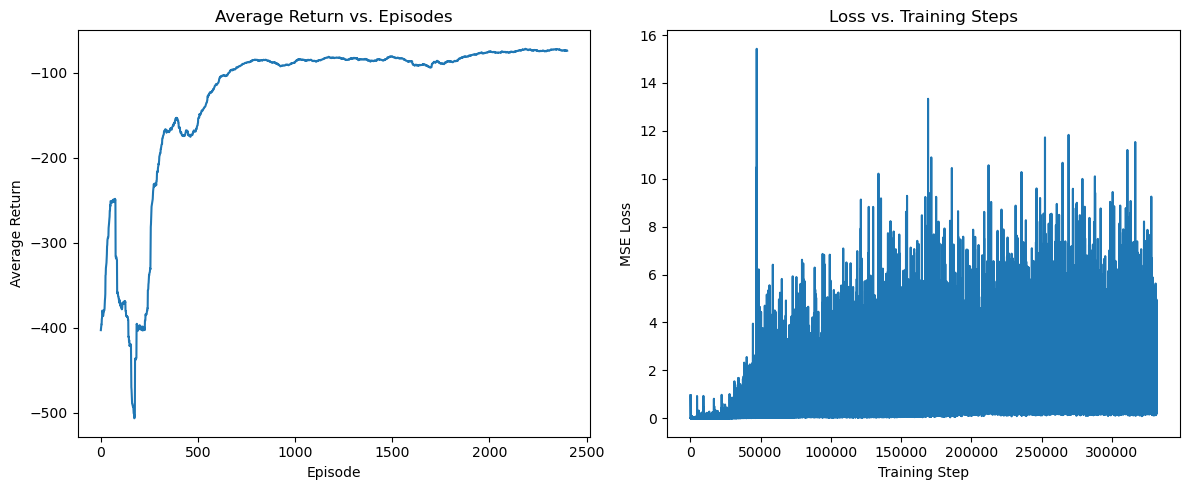

In [1]:
epsilon = EPSILON
for episode in range(NUM_EPISODES):
    state, _ = env.reset()
    state = torch.FloatTensor(state)
    total_reward = 0
    done = False
    
    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = q_network(state)
                action = torch.argmax(q_values).item()
        
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        replay_buffer.add((state, action, reward, torch.FloatTensor(next_state), done))
        state = torch.FloatTensor(next_state)
        
        # Training
        if len(replay_buffer) >= BATCH_SIZE:
            batch = replay_buffer.sample(BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.stack(states)
            actions = torch.tensor(actions)
            rewards = torch.tensor(rewards)
            next_states = torch.stack(next_states)
            dones = torch.tensor(dones, dtype=torch.float32)

            q_values = q_network(states).gather(1, actions.unsqueeze(-1)).squeeze()
            next_q_values = target_network(next_states).max(1)[0]
            target_q_values = rewards + GAMMA * next_q_values * (1 - dones)

            loss = nn.MSELoss()(q_values, target_q_values.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

    returns.append(total_reward)
    epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)

    # Update target network
    if episode % TARGET_UPDATE_FREQ == 0:
        target_network.load_state_dict(q_network.state_dict())
    
    # Logging
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}: Return = {np.mean(returns[-100:]):.2f}, Loss = {np.mean(losses[-100:]):.4f}")

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.convolve(returns, np.ones(100)/100, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('Average Return')
plt.title('Average Return vs. Episodes')

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('MSE Loss')
plt.title('Loss vs. Training Steps')

plt.tight_layout()
plt.show()